# Comparison of Models

Some imports

In [26]:
import os
import sklearn
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import tree
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
import pydotplus
import numpy as np
import pandas as pd

Utility function

In [ ]:
# Function to create a tree diagram
def create_tree_graph_png(tree, feature_names):
    tree_str = export_graphviz(tree, feature_names=feature_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png('tree.png')
    return Image(graph.create_png())

def display_regression_results(price_test, price_preds):
    # Display the results
    plt.figure()
    plt.scatter(range(len(price_test)), price_test, c="darkorange", label="Price real values")
    plt.plot(range(len(price_preds)), price_preds, color="cornflowerblue", label="Price predictions", linewidth=2)
    plt.xlabel("Prices")
    plt.ylabel("Instances")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

Loading dataset

In [38]:
data_train = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_train.csv")
data_val = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_val.csv")
data_test = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_test.csv")
print(len(data_train), len(data_val), len(data_test))

9772 2443 3054


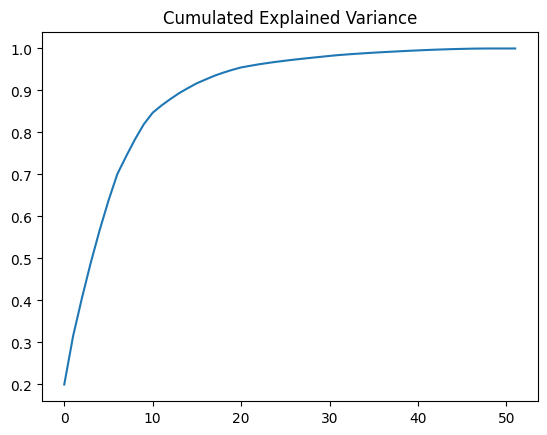

In [39]:
# Best features selected in dimensionality reduction part
features = [
    "Accomodates",
    "Bathrooms",
    "Bedrooms",
    "Guests Included",
    "Property Type_Apartment",
    "Property Type_Hotel",
    "Room Type_Entire home/apt",
    "dist_to_center"
]

X_train_best_feat = data_train[features]
y_train = data_train['Price']
X_val_best_feat = data_val[features]
y_val = data_val['Price']
X_test_best_feat = data_test[features]
y_test = data_test['Price']

# PCA reduction
pca = PCA()
columns = list(data_train.columns)
columns.remove("Price")
X_train_pca = pca.fit_transform(data_train[columns])
y_train = data_train['Price']
X_val_pca = pca.transform(data_val[columns])
y_val = data_val['Price']
X_test_pca = pca.transform(data_test[columns])
y_test = data_test['Price']

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulated Explained Variance")
plt.show()

In [40]:
X_train_pca = X_train_pca[:, :10]
X_val_pca = X_train_pca[:, :10]
X_test_pca = X_train_pca[:, :10]

In [41]:
from sklearn.linear_model import LinearRegression

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
score_pca = -1*model_selection.cross_val_score(
    regr,
    X_train_pca,
    y_train.ravel(),
    cv=kf_10,
    scoring='neg_mean_squared_error'
).mean()

score_best_features = -1*model_selection.cross_val_score(
    regr,
    X_train_best_feat,
    y_train.ravel(),
    cv=kf_10,
    scoring='neg_mean_squared_error'
).mean()

In [42]:
print(score_pca, score_best_features)

1678.9704383242486 1359.6801169785672


In [43]:
X_train = X_train_best_feat
X_val = X_val_best_feat
X_test = X_test_best_feat

### Decision Tree

In [44]:
pgrid = {
    "max_depth": range(4, 34),
    "min_samples_split": range(100, 1000, 100)
}
grid_search = GridSearchCV(
    tree.DecisionTreeRegressor(),
    param_grid=pgrid,
    scoring='neg_mean_squared_error',
    cv=10
)
grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
print("MSE Decision Tree with Cross Validation: ", mean_squared_error(y_test, y_pred))
print("max_depth: ", grid_search.best_params_["max_depth"])
print("min_samples_split: ", grid_search.best_params_["min_samples_split"])

MSE Decision Tree with Cross Validation:  1837.0034046827432
max_depth:  5
min_samples_split:  300


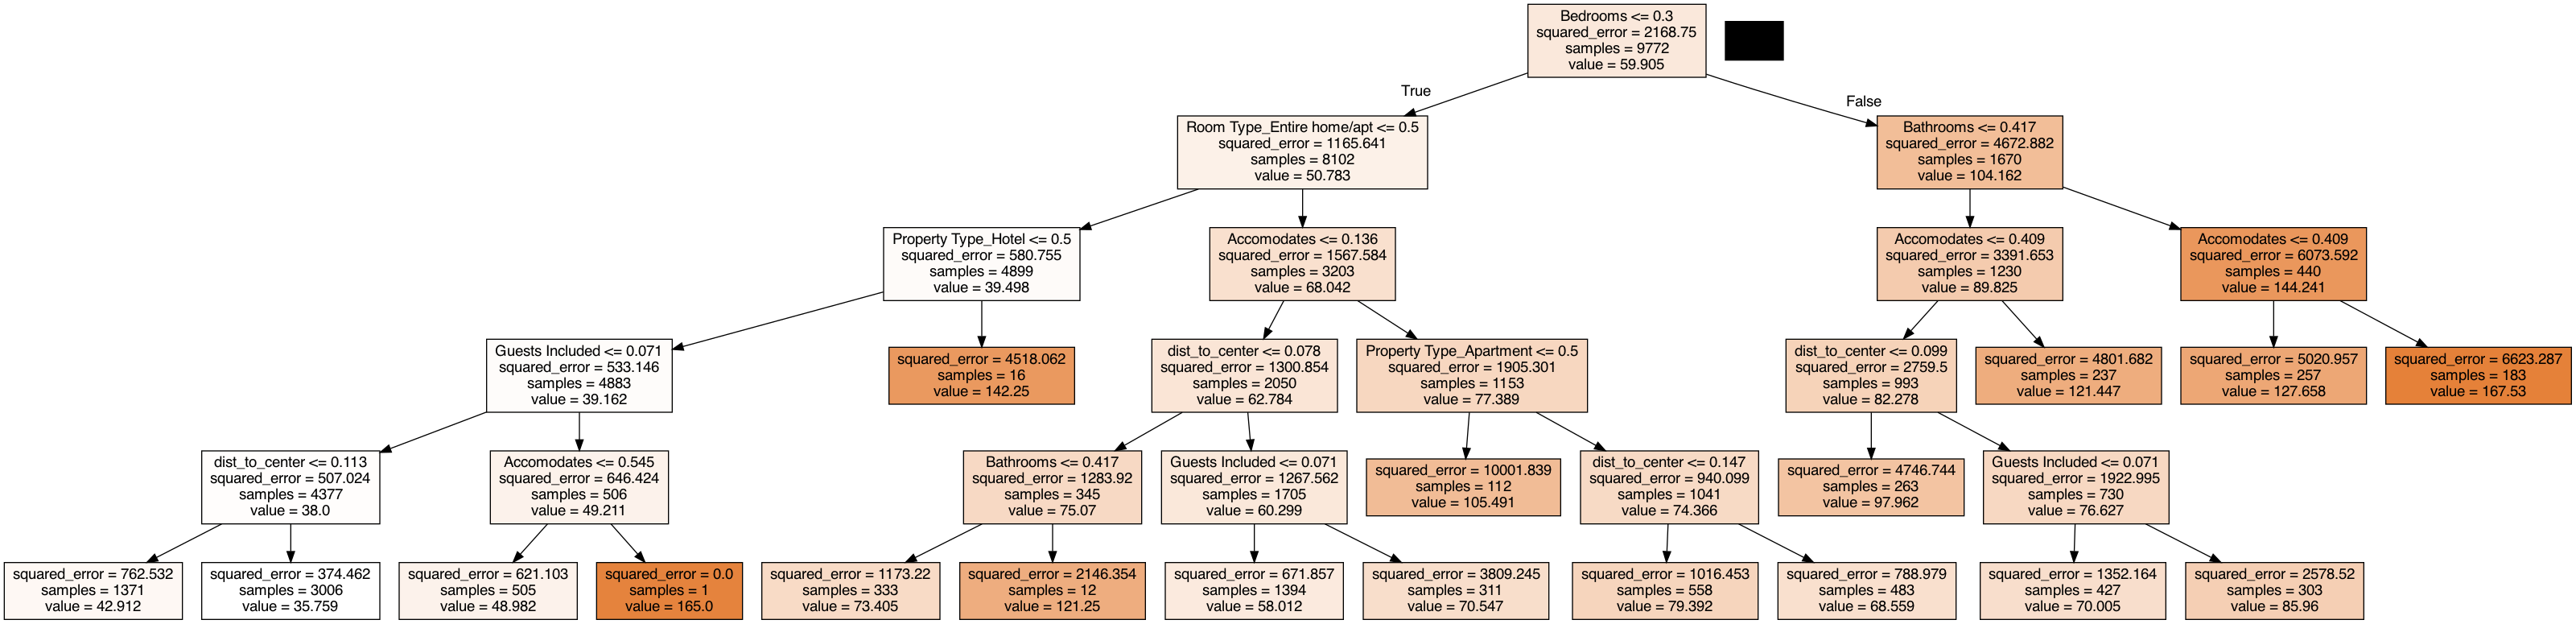

In [45]:
create_tree_graph_png(grid_search.best_estimator_, X_train.columns)

### Random Forests

In [46]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 400
clf = RandomForestRegressor(n_estimators=n_estimators)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"MSE Random Forest n_estimators={n_estimators}:", mean_squared_error(y_test, y_pred))

MSE Random Forest n_estimators=400: 2029.706216212993


In [47]:
pgrid = {
    "n_estimators": range(300, 1000, 100)
}
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=pgrid,
    scoring='neg_mean_squared_error',
    cv=10
)
grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
print("MSE Random Forest with Cross Validation: ", mean_squared_error(y_test, y_pred))
print("n_estimators: ", grid_search.best_params_)

KeyboardInterrupt: 

### Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

pgrid = {
    "max_samples": [0.2, 0.4, 0.6, 0.8],
    "max_features": [0.2, 0.4, 0.6, 0.8]}
grid_search = GridSearchCV(BaggingRegressor(tree.DecisionTreeRegressor()), param_grid=pgrid, cv=5)
grid_search.fit(X_train, y_train)
y_pred=grid_search.best_estimator_.predict(X_test)
best_max_samples=grid_search.best_estimator_.max_samples
best_max_features=grid_search.best_estimator_.max_features
print("MSE Bagging with Cross Validation: ", mean_squared_error(y_test, y_pred))
print("best_max_samples ", best_max_samples)
print("best_max_features ", best_max_features)

MSE:  0.0024200667206962455
best_max_samples  0.2
best_max_features  0.8


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

lr = 0.1
gradient_booster = GradientBoostingRegressor(learning_rate=lr)
gradient_booster.fit(X_train,y_train)
y_pred = gradient_booster.predict(X_test)
print(f"MSE Gradient Boosting lr={lr}: ", mean_squared_error(y_test, y_pred))

MSE:  0.002219153173731952


In [ ]:
pgrid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "n_estimators": range(10, 1000, 100)}
grid_search = GridSearchCV(BaggingRegressor(tree.DecisionTreeRegressor()), param_grid=pgrid, cv=5)
grid_search.fit(X_train, y_train)
y_pred=grid_search.best_estimator_.predict(X_test)
best_learning_rate=grid_search.best_estimator_.learning_rate
best_n_estimators=grid_search.best_estimator_.n_estimators

print("MSE Gradient Boosting with Cross Validation: ", mean_squared_error(y_test, y_pred))
print("best_learning_rate ", best_learning_rate)
print("best_n_estimators ", best_n_estimators)

### AdaBoost

In [4]:
from sklearn.ensemble import AdaBoostRegressor

lr = 0.1
ada_booster = AdaBoostRegressor(learning_rate=lr)
ada_booster.fit(X_train,y_train)
y_pred = ada_booster.predict(X_test)
print(f"MSE AdaBoost lr={lr}: ", mean_squared_error(y_test, y_pred))


MSE AdaBoost lr=0.1:  0.002555899035358558


Time to run CV: 

In [5]:
pgrid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "n_estimators": range(10, 1000, 100)}
grid_search = GridSearchCV(AdaBoostRegressor(tree.DecisionTreeRegressor()), param_grid=pgrid, cv=5)
grid_search.fit(X_train, y_train)
y_pred=grid_search.best_estimator_.predict(X_test)
best_learning_rate=grid_search.best_estimator_.learning_rate
best_n_estimators=grid_search.best_estimator_.n_estimators

print("MSE AdaBoost with Cross Validation: ", mean_squared_error(y_test, y_pred))
print("best_learning_rate ", best_learning_rate)
print("best_n_estimators ", best_n_estimators)

KeyboardInterrupt: 